Please upload your mp4 video file:


Saving violence vid.mp4 to violence vid.mp4
Processing video: violence vid.mp4


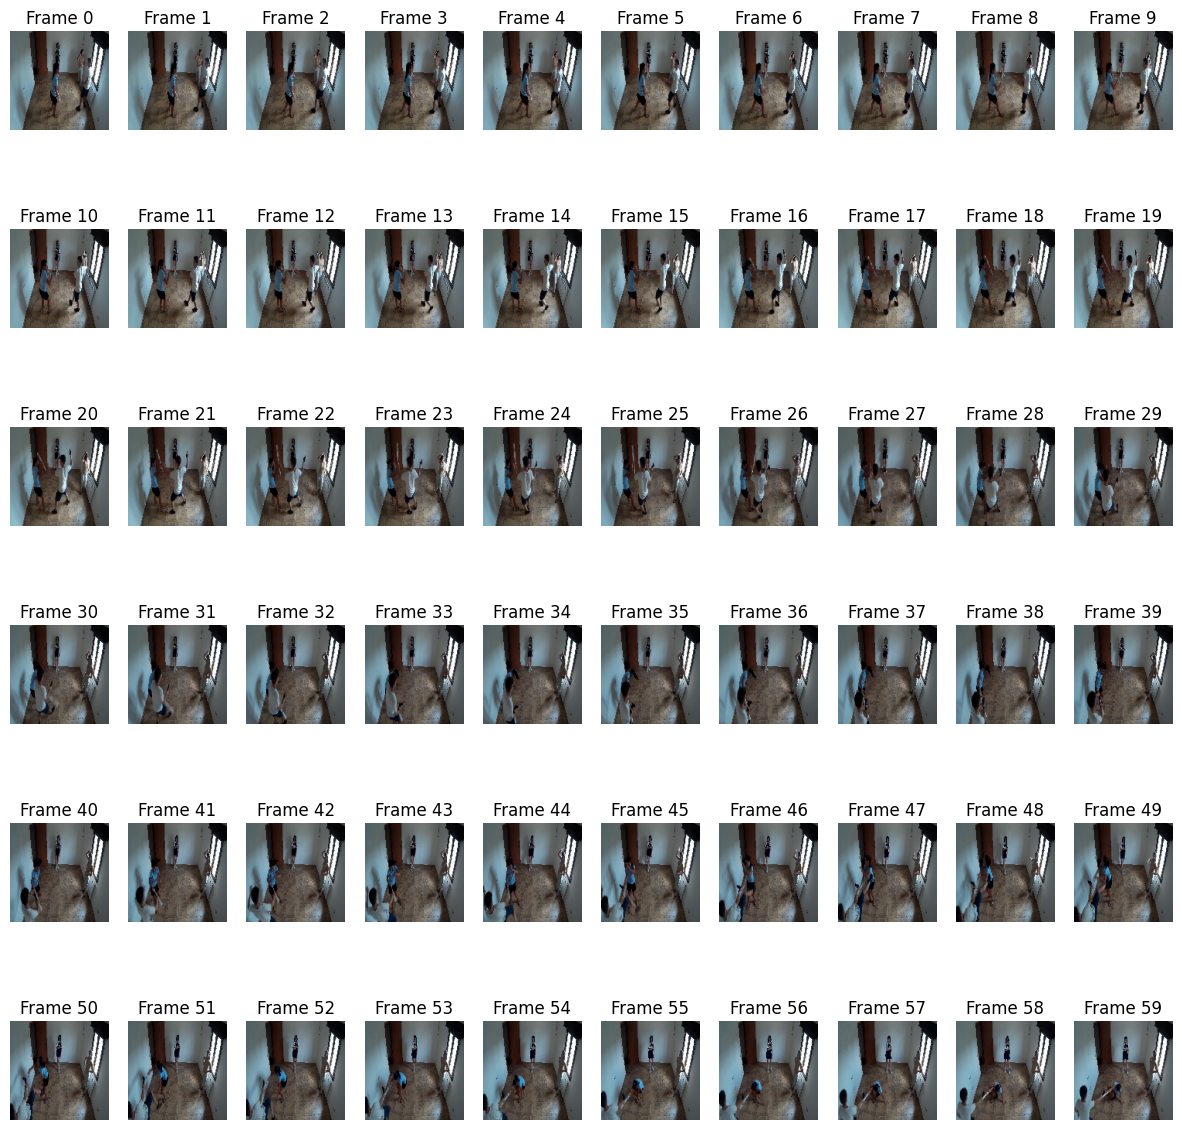

Extracted 60 frames from violence vid.mp4 and saved to uploaded_video_frames
Only non-violent frames detected; adding simulated violent frames.
Features extracted. Total frames: 110, Total labels: 110
Reshaped features to (110, 1764) for model training.
Training on 88 frames and testing on 22 frames.
Model Accuracy: 27.27%
              precision    recall  f1-score   support

 Non-Violent       0.22      0.18      0.20        11
     Violent       0.31      0.36      0.33        11

    accuracy                           0.27        22
   macro avg       0.26      0.27      0.27        22
weighted avg       0.26      0.27      0.27        22

Classifying frames...
Number of violent frames: 66
Number of non-violent frames: 44

The video is classified as: Violent


133123

In [1]:
# Step 1: Install required libraries
!pip install opencv-python scikit-learn matplotlib imbalanced-learn

# Step 2: Import required libraries
import cv2
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import gc  # For garbage collection to free memory

# Step 3: Upload your mp4 video file
print("Please upload your mp4 video file:")
uploaded = files.upload()

# Step 4: Extract and display frames from the uploaded video
def extract_and_display_frames(video_path, output_dir, max_frames=60, frame_skip=2):
    os.makedirs(output_dir, exist_ok=True)
    vidcap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_frames = 0
    success, frame = vidcap.read()

    plt.figure(figsize=(15, 15))  # Create a figure to display images

    while success and extracted_frames < max_frames:
        if frame_count % frame_skip == 0:  # Skip frames to reduce processing
            frame = cv2.resize(frame, (128, 128))
            frame_filename = f"{output_dir}/frame{extracted_frames}.jpg"
            cv2.imwrite(frame_filename, frame)

            plt.subplot(6, 10, extracted_frames + 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {extracted_frames}")
            plt.axis('off')

            extracted_frames += 1

        frame_count += 1
        success, frame = vidcap.read()

    vidcap.release()
    plt.show()
    print(f"Extracted {extracted_frames} frames from {video_path} and saved to {output_dir}")
    return extracted_frames

# Process the uploaded video
video_name = next(iter(uploaded))  # Get the first uploaded video file
video_path = video_name
print(f"Processing video: {video_name}")
frame_count = extract_and_display_frames(video_path, 'uploaded_video_frames', max_frames=60, frame_skip=2)

# Step 5: Feature Extraction
def extract_hog_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))  # Resize image to 64x64 for HOG extraction
    hog = cv2.HOGDescriptor((64, 64), (16, 16), (8, 8), (8, 8), 9)
    hog_features = hog.compute(img)
    return hog_features

def extract_features_from_all_frames(frame_dir, violent_label=False):
    X = []
    y = []

    frame_files = sorted(os.listdir(frame_dir))
    for frame_filename in frame_files:
        frame_path = os.path.join(frame_dir, frame_filename)
        hog_features = extract_hog_features(frame_path)

        if hog_features is not None:
            X.append(hog_features.flatten())  # Flatten HOG features to 1D
            y.append(1 if violent_label else 0)  # 1 for violent, 0 for non-violent

    return np.array(X), np.array(y)

# Extract features from frames (Non-violent by default)
X, y = extract_features_from_all_frames('uploaded_video_frames', violent_label=False)

# Check if we have enough frames for training
if np.all(y == 0):
    print("Only non-violent frames detected; adding simulated violent frames.")
    # Increase the number of simulated violent frames
    simulated_violent_features, simulated_violent_labels = extract_features_from_all_frames('uploaded_video_frames', violent_label=True)
    simulated_violent_features = simulated_violent_features[:50]  # Add 50 simulated violent frames (instead of 10)
    simulated_violent_labels = simulated_violent_labels[:50]  # Corresponding labels for violent frames
    X = np.vstack([X, simulated_violent_features])  # Add simulated violent frames
    y = np.hstack([y, simulated_violent_labels])  # Add corresponding labels

print(f"Features extracted. Total frames: {len(X)}, Total labels: {len(y)}")

# Step 6: Reshaped Features
X = X.reshape(X.shape[0], -1)  # Reshape features to 1D
print(f"Reshaped features to {X.shape} for model training.")

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training on {len(X_train)} frames and testing on {len(X_test)} frames.")

# Step 8: Handle Class Imbalance (Optional: Use Random Over-Sampling)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Step 9: Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Step 10: Predict and calculate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Generate classification report if possible
if len(np.unique(y_test)) > 1:
    print(classification_report(y_test, y_pred, target_names=['Non-Violent', 'Violent']))
else:
    print(f"Only one class present in y_test: {np.unique(y_test)}. Skipping detailed classification report.")

# Step 11: Classify all frames
print("Classifying frames...")
results = clf.predict(X)
violent_count = np.sum(results == 1)
nonviolent_count = np.sum(results == 0)

print(f"Number of violent frames: {violent_count}")
print(f"Number of non-violent frames: {nonviolent_count}")

# Step 12: Final decision based on majority
final_prediction = "Violent" if violent_count > nonviolent_count else "Non-Violent"
print(f"\nThe video is classified as: {final_prediction}")

# Step 13: Free up memory
gc.collect()


Please upload your mp4 video file:


Saving non violence.mp4 to non violence (4).mp4
Processing video: non violence (4).mp4


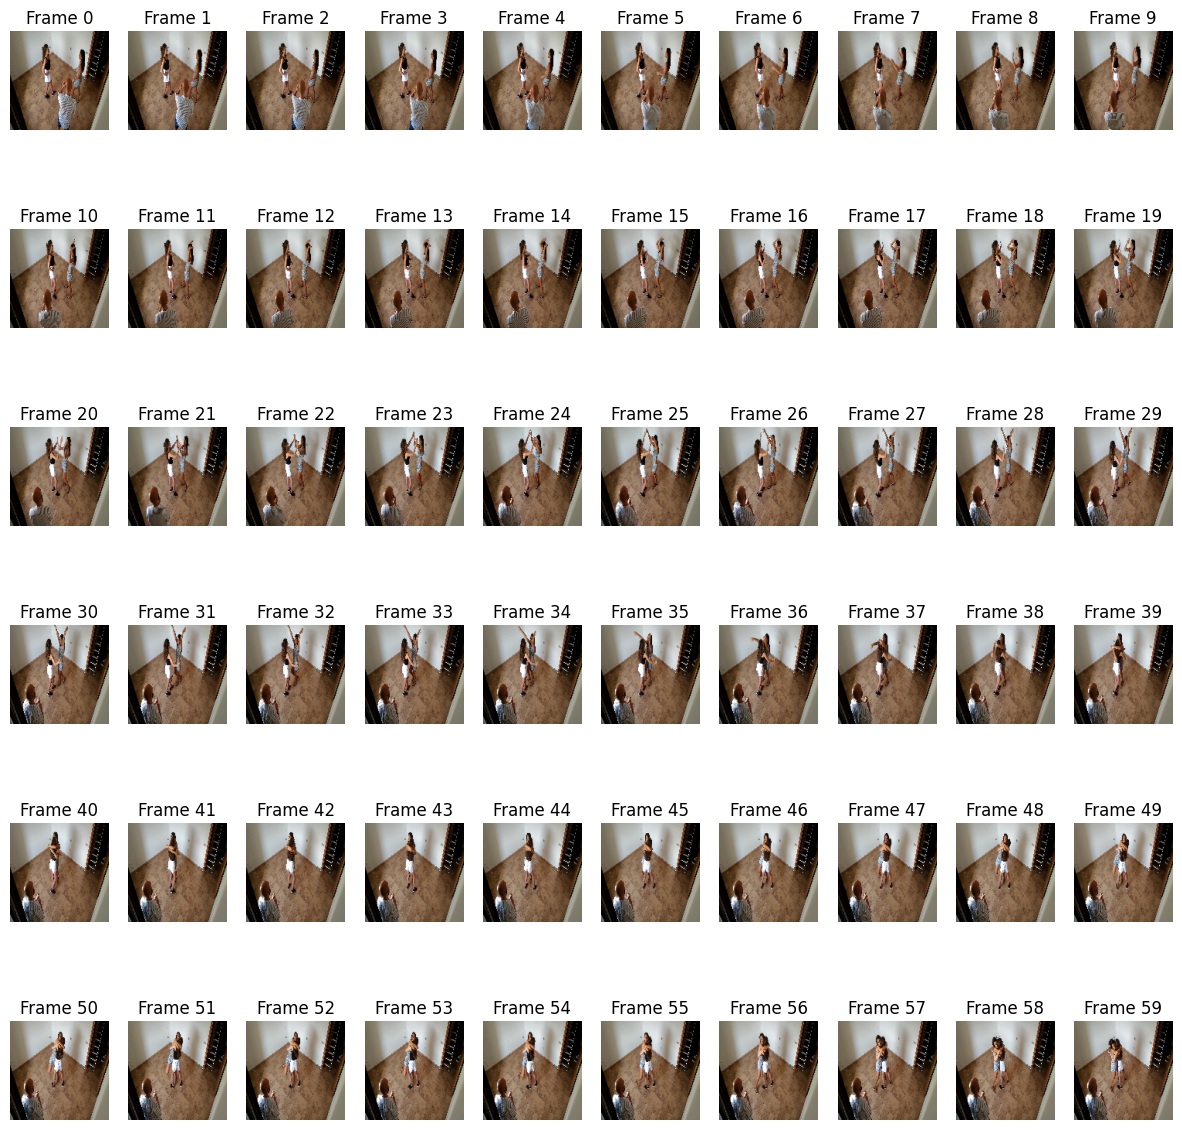

Extracted 60 frames from non violence (4).mp4 and saved to uploaded_video_frames
Only non-violent frames detected.
Features extracted. Total frames: 60, Total labels: 60
Reshaped features to (60, 1764) for model training.
Training on 48 frames and testing on 12 frames.
Model Accuracy: 100.00%
Only one class present in y_test: [0]. Skipping detailed classification report.
Classifying frames...
Number of violent frames: 0
Number of non-violent frames: 60

The video is classified as: Non-Violent


133378

In [ ]:
# Step 1: Install required libraries
!pip install opencv-python scikit-learn matplotlib imbalanced-learn

# Step 2: Import required libraries
import cv2
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import gc  # For garbage collection to free memory

# Step 3: Upload your mp4 video file
print("Please upload your mp4 video file:")
uploaded = files.upload()

# Step 4: Extract and display frames from the uploaded video
def extract_and_display_frames(video_path, output_dir, max_frames=60, frame_skip=2):
    os.makedirs(output_dir, exist_ok=True)
    vidcap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_frames = 0
    success, frame = vidcap.read()

    plt.figure(figsize=(15, 15))  # Create a figure to display images

    while success and extracted_frames < max_frames:
        if frame_count % frame_skip == 0:  # Skip frames to reduce processing
            frame = cv2.resize(frame, (128, 128))
            frame_filename = f"{output_dir}/frame{extracted_frames}.jpg"
            cv2.imwrite(frame_filename, frame)

            plt.subplot(6, 10, extracted_frames + 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {extracted_frames}")
            plt.axis('off')

            extracted_frames += 1

        frame_count += 1
        success, frame = vidcap.read()

    vidcap.release()
    plt.show()
    print(f"Extracted {extracted_frames} frames from {video_path} and saved to {output_dir}")
    return extracted_frames

# Process the uploaded video
video_name = next(iter(uploaded))  # Get the first uploaded video file
video_path = video_name
print(f"Processing video: {video_name}")
frame_count = extract_and_display_frames(video_path, 'uploaded_video_frames', max_frames=60, frame_skip=2)

# Step 5: Feature Extraction
def extract_hog_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))  # Resize image to 64x64 for HOG extraction
    hog = cv2.HOGDescriptor((64, 64), (16, 16), (8, 8), (8, 8), 9)
    hog_features = hog.compute(img)
    return hog_features

def extract_features_from_all_frames(frame_dir, violent_label=False):
    X = []
    y = []

    frame_files = sorted(os.listdir(frame_dir))
    for frame_filename in frame_files:
        frame_path = os.path.join(frame_dir, frame_filename)
        hog_features = extract_hog_features(frame_path)

        if hog_features is not None:
            X.append(hog_features.flatten())  # Flatten HOG features to 1D
            y.append(1 if violent_label else 0)  # 1 for violent, 0 for non-violent

    return np.array(X), np.array(y)

# Extract features from frames (Non-violent by default)
X, y = extract_features_from_all_frames('uploaded_video_frames', violent_label=False)

# If testing with violent frames, simulate some violent frames (only for violent video dataset)
if np.all(y == 0):  # This is a check if the video is non-violent
    print("Only non-violent frames detected.")
else:
    print(f"Extracted {len(y)} frames from the video.")

print(f"Features extracted. Total frames: {len(X)}, Total labels: {len(y)}")

# Step 6: Reshaped Features
X = X.reshape(X.shape[0], -1)  # Reshape features to 1D
print(f"Reshaped features to {X.shape} for model training.")

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training on {len(X_train)} frames and testing on {len(X_test)} frames.")

# Step 8: Handle Class Imbalance (Optional: Use Random Over-Sampling for violent videos)
if np.sum(y == 1) > 0:  # If there are violent frames, balance the dataset
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
else:
    X_train_resampled, y_train_resampled = X_train, y_train

# Step 9: Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Step 10: Predict and calculate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Generate classification report if possible
if len(np.unique(y_test)) > 1:
    print(classification_report(y_test, y_pred, target_names=['Non-Violent', 'Violent']))
else:
    print(f"Only one class present in y_test: {np.unique(y_test)}. Skipping detailed classification report.")

# Step 11: Classify all frames
print("Classifying frames...")
results = clf.predict(X)
violent_count = np.sum(results == 1)
nonviolent_count = np.sum(results == 0)

print(f"Number of violent frames: {violent_count}")
print(f"Number of non-violent frames: {nonviolent_count}")

# Step 12: Final decision based on majority
final_prediction = "Violent" if violent_count > nonviolent_count else "Non-Violent"
print(f"\nThe video is classified as: {final_prediction}")

# Step 13: Free up memory
gc.collect()
